# Домашнее задание №2

Задание присылать на почту **aleksartmonov@gmail.com** в форматах *.ipynb* и отрендеренный результат в *.html*

В теме письма указать **AU2018 HW2 <Фамилия Имя>**

soft deadline: 04.03.2018T23:59:00+0300

hard deadline: 11.03.2018T23:59:00+0300

In [1]:
%matplotlib inline

import cv2
import numpy as np
import ipywidgets as wg
import matplotlib.pylab as plt

from itertools import chain, product
from matplotlib.colors import LogNorm

In [2]:
def show(images):
    def expand():
        if isinstance(images, (np.ndarray, tuple)):
            return [[images]]
        elif isinstance(images[0], (np.ndarray, tuple)):
            return [images]
        else:
            return images
    
    def plot(ax, img):
        if isinstance(img, tuple):
            img, name = img
        else:
            name = ''
        ax.set_title(name)
        ax.set_axis_off()
        if len(img.shape) == 3:
            ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:
            if img.dtype == np.complex128:
                ax.imshow(np.abs(img), norm=LogNorm(), cmap='gray')
            else:
                ax.imshow(img, cmap='gray')
    
    images = expand()
    nrows, ncols = len(images), max(len(row) for row in images)
    _, axes = plt.subplots(nrows=nrows, ncols=ncols, 
                           figsize=(ncols * 7, nrows * 7), squeeze=False)
    
    for axes_row, imgs_row in zip(axes, images):
        for ax, img in zip(axes_row, imgs_row):
            plot(ax, img)

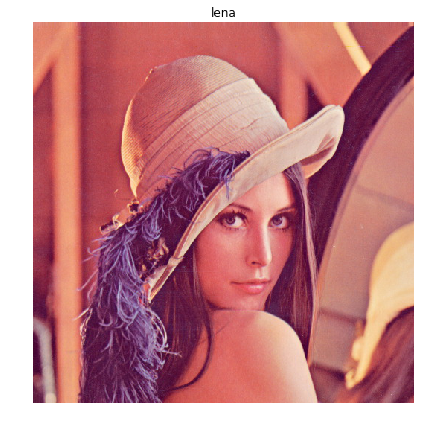

In [3]:
lena = cv2.imread("lena.jpg")
show((lena, 'lena'))

**1. (6 баллов)** С помощью [виджетов](http://ipywidgets.readthedocs.io/en/latest/examples/Widget%20List.html) создайте 2 слайдера с настройками параметров гамма-коррекции. Отобразите **lena**, ее гамма-преобразование и график в диапозоне от [0;1], так, чтобы параметры слайдера соответствовали параметрам гамма-коррекции. 

In [4]:
def adjust_gamma(image, const, gamma):
    x = np.linspace(0, 1, 256)
    y = (x ** gamma) * 255 * const
    y[y > 255] = 255
    plt.title(f'const={const} gamma={gamma}')
    plt.plot(x, y / 255);
    return cv2.LUT(image, y).astype(np.uint8)

In [5]:
wg.interact(lambda const, gamma: show(adjust_gamma(lena, const, gamma)), 
            const=wg.FloatSlider(value=1, min=0, max=10, step=0.01, continuous_update=False), 
            gamma=wg.FloatSlider(value=1, min=0, max=10, step=0.01, continuous_update=False));

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='const', max=10.0, step=0.01), FloatSlider(value=1.0, continuous_update=False, description='gamma', max=10.0, step=0.01), Output()), _dom_classes=('widget-interact',))

**2. (3 балла)** Загрузите изображение $lena.jpg$. Переведите изображение в градации серого. Примените к серому изображению операцию линейного растяжения диапазона яркостей ($normalize$) и эквализации гистограммы ($equalizeHist$). Постройте разность полученных результатов. Состыкуйте в одно изображение в градациях серого результат линейного растяжения, эквализации и их разности.

In [6]:
def diff(image1, image2):
    return np.abs(image1.astype(float) - image2.astype(float)).astype(np.uint8)

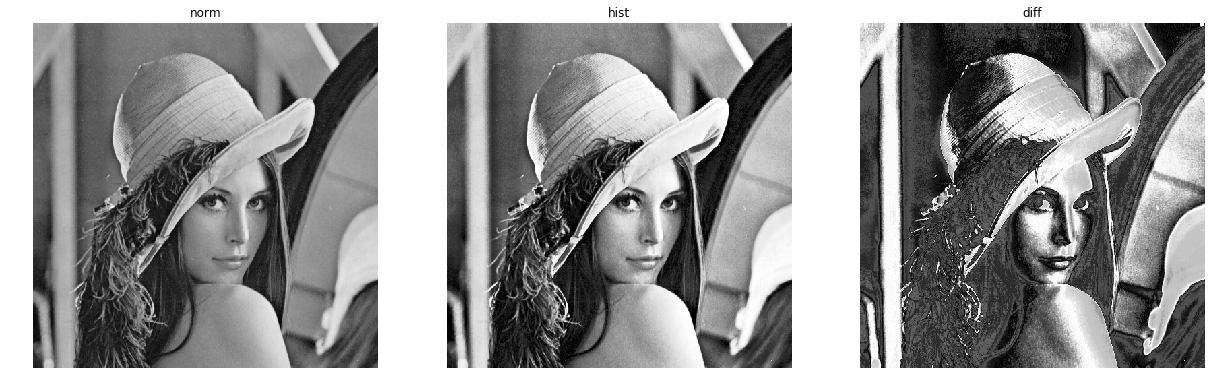

In [7]:
lena_gray = cv2.cvtColor(lena, cv2.COLOR_BGR2GRAY)
lena_norm = cv2.normalize(lena_gray, np.zeros_like(lena), 0, 255, cv2.NORM_MINMAX)
lena_hist = cv2.equalizeHist(lena_gray, np.zeros_like(lena))
show([(lena_norm, 'norm'), (lena_hist, 'hist'), (diff(lena_norm, lena_hist), 'diff')])

**3. (3 балла) ** Реализуйте функцию добавления шума «соль и перец» для одноканального изображения. Входные параметры: $src$ – исходная одноканальная матрица $Mat$, $p$ – вероятность замещения исходных значений на $0$, $q$ – вероятность замещения исходных значений на $255$. Загрузите изображение $lena.jpg$, выделите каналы изображения в отдельные матрицы ($split$), добавьте шум «соль и перец» в каждый канал при помощи реализованной Вами функции с параметрами

1. $p=q=0.05$
2. $p=q=0.1$
3. $p=q=0.15$

In [8]:
def salt_pepper(src, p, q):
    res = src.copy()
    mask = np.random.uniform(0, 1, size=src.shape)
    res[mask <= p], res[mask >= (1 - q)] = 0, 255
    return res


def sp_distortion(src, p):
    return np.dstack(salt_pepper(s[:, :, 0], p, p) for s in np.dsplit(src, 3))

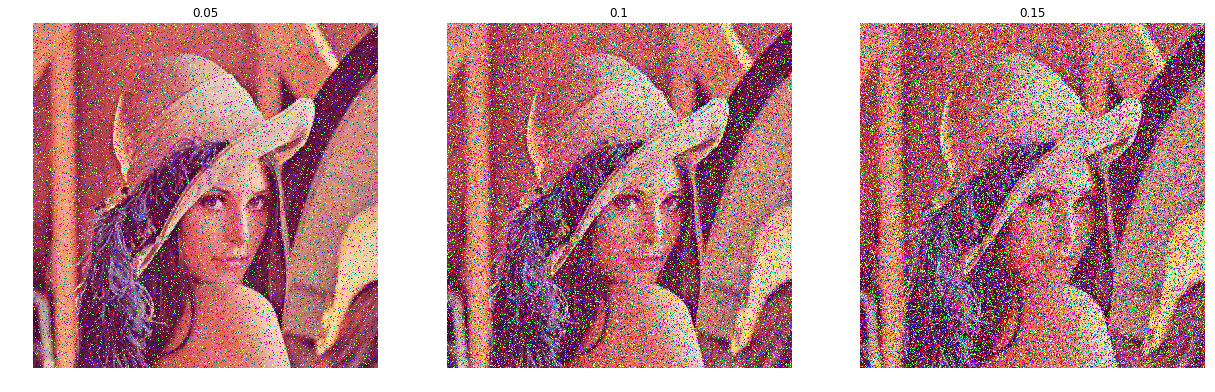

In [9]:
show([(sp_distortion(lena, 0.05), '0.05'), 
      (sp_distortion(lena, 0.1), '0.1'), 
      (sp_distortion(lena, 0.15), '0.15')])

**5. (6 баллов)** Загрузите изображение $lena.jpg$ (512х512). Переведите изображение в градации серого. Произведите фильтрацию данного изображения в частотной области идеальным фильтром низких частот (фильтр, обрезающий все высокочастотные составляющие Фурье-образа, находящиеся на большем расстоянии от начала координат, чем некоторое заданное расстояние $D$), идеальным фильтром высоких частот (фильтр, обрезающий все низкокочастотные составляющие Фурье-образа, находящиеся на меньшем расстоянии от начала координат, чем некоторое заданное расстояние $D$) со  значениями радиуса фильтров, которые будут задаваться с помощью слайдера, как в задании **1**.

Для каждого фильтра постройте состыкованное изображение из следующих: исходное изображение в градациях серого, изображение Фурье-спектра (после логарифмической коррекции для лучшей визуализации), изображение Фурье-спектра после фильтрации, изображение в пространственной области после фильтрации. Итого для каждого $D$ должно рисоваться 8 картинок. 

In [10]:
def fft(image):
    return np.fft.fftshift(np.fft.fft2(image.astype(float)))


def ifft(fimage):
    return np.abs(np.fft.ifft2(np.fft.ifftshift(fimage))).astype(np.uint8)

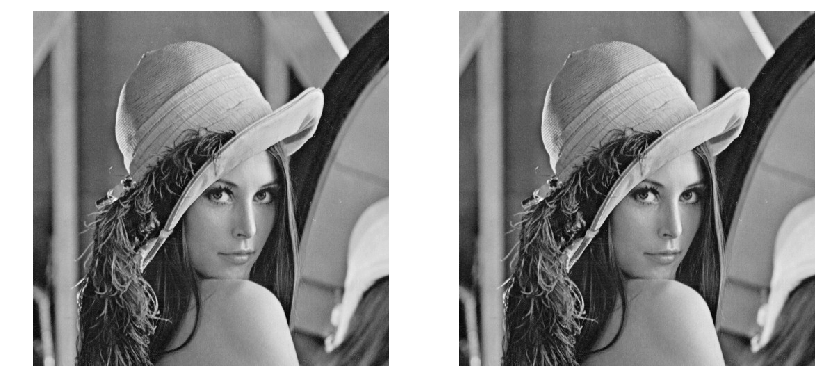

In [11]:
show([lena_gray, ifft(fft(lena_gray))])

In [12]:
def fft_dist_filter(fft_image, d, inner):
    n, *_ = fft_image.shape
    r, n2 = int(n * d), int(n / 2)
    y, x = np.ogrid[-n2:n2, -n2:n2]
    coords = x ** 2 + y ** 2
    mask = (coords < r ** 2) if inner else (coords > r ** 2)
    fft_image = fft_image.copy()
    fft_image[mask] = 0
    return fft_image


def fft_filter_cascade(image, d, inner):
    image_fft = fft(image)
    image_fft_filter = fft_dist_filter(image_fft, d, inner)
    image_filter = ifft(image_fft_filter)
    return [image, image_fft, image_fft_filter, image_filter]


def fft_filter_both(image, d):
    return [fft_filter_cascade(image, d, True), 
            fft_filter_cascade(image, d, False)]

In [13]:
wg.interact(lambda d: show(fft_filter_both(lena_gray, d)),
            d=wg.FloatSlider(value=0.1, min=0, max=1, step=0.01, continuous_update=False));

interactive(children=(FloatSlider(value=0.1, continuous_update=False, description='d', max=1.0, step=0.01), Output()), _dom_classes=('widget-interact',))

**6. (5 баллов) **Удалите диагональные полоски с изображения $lena\_diagonal.jpg$. Вычислите среднеквадратичную ошибку (mean squared error, $MSE$, \url{http://en.wikipedia.org/wiki/Mean_squared_error}) для полученного результата и изображения $lena\_gray\_512.tif$. Задача будет засчитана при $MSE < 1500$. Тот, у кого по результатам проверки будет наименьшее значение MSE среди всех студентов для этой задачи, получит призовую шоколадку (раньше мы раздавали призовые баллы, но теперь у нас концепция фиксированного максимального количества баллов)

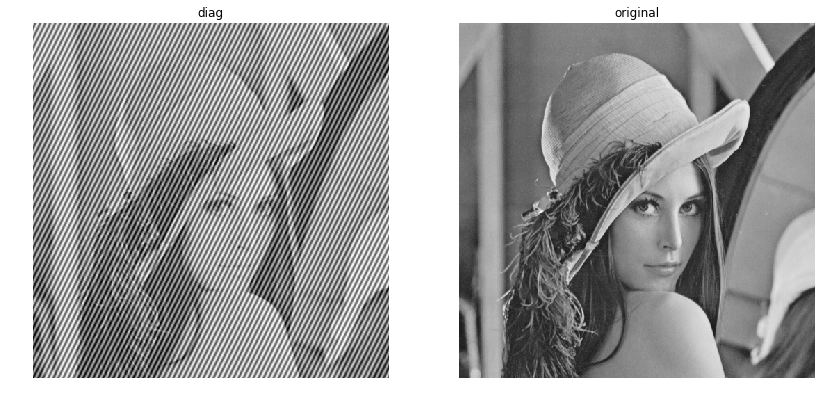

In [14]:
lena_diag3 = cv2.imread('lena_diagonal.jpg')
lena_gray3 = cv2.imread('lena_gray_512.tif')
show([(lena_diag3, 'diag'), (lena_gray3, 'original')])

In [15]:
def mse(image1, image2):
    return ((image1.astype(float) - image2.astype(float)) ** 2).mean()

In [16]:
mse(lena_diag3, lena_gray3)

3484.66450881958

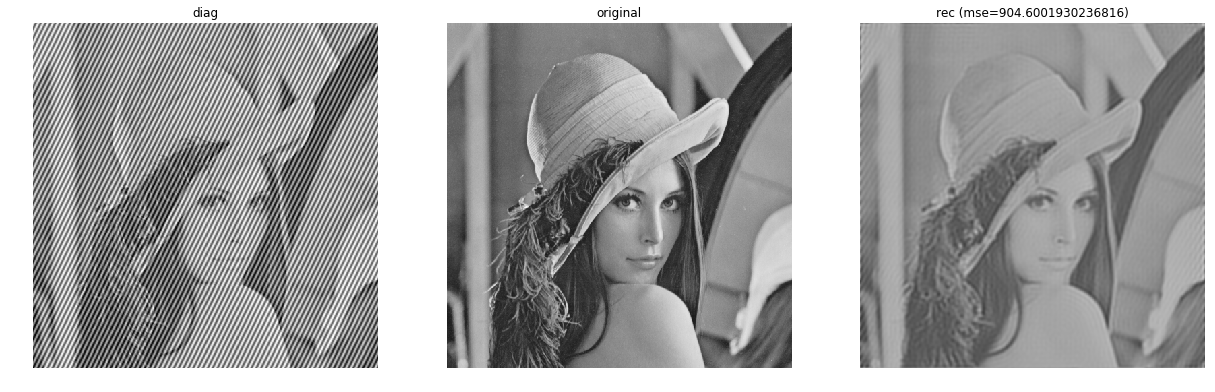

In [17]:
lena_diag1 = cv2.cvtColor(lena_diag3, cv2.COLOR_BGR2GRAY)
lena_gray1_rec = fft_filter_cascade(lena_diag1, 0.14, False)[3]
lena_gray3_rec = cv2.cvtColor(lena_gray1_rec, cv2.COLOR_GRAY2BGR)
error = mse(lena_gray3, lena_gray3_rec)
assert error < 1500
show([(lena_diag3, 'diag'), (lena_gray3, 'original'), (lena_gray3_rec, f'rec (mse={error})')])

**7. (5 баллов)** Подавите шум на изображении $lena\_color\_512\_noise.tif$. Вычислите среднеквадратичную ошибку ($MSE$) для полученного результата и изображения $lena\_color\_512.tif$. Задача будет засчитана при $MSE < 150$. Тот, у кого по результатам проверки будет наименьшее значение $MSE$ среди всех студентов для этой задачи, получит призовую шоколадку.

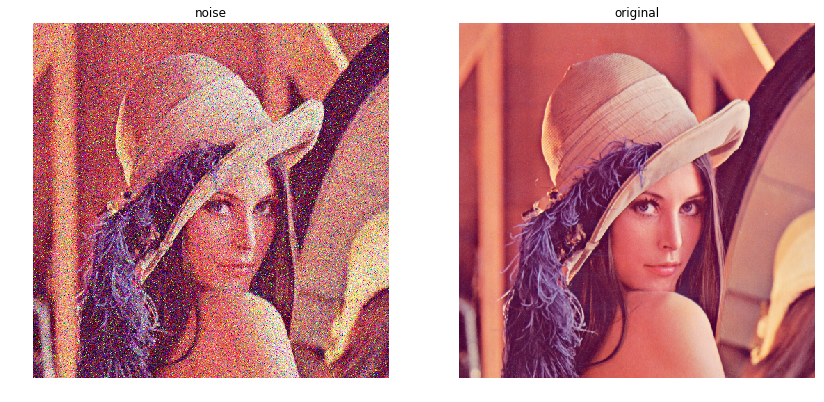

In [18]:
lena_noise = cv2.imread('lena_color_512-noise.tif')
lena_tiff = cv2.imread('lena_color_512.tif')
show([(lena_noise, 'noise'), (lena_tiff, 'original')])

In [19]:
mse(lena_noise, lena_tiff)

2184.1810162862143

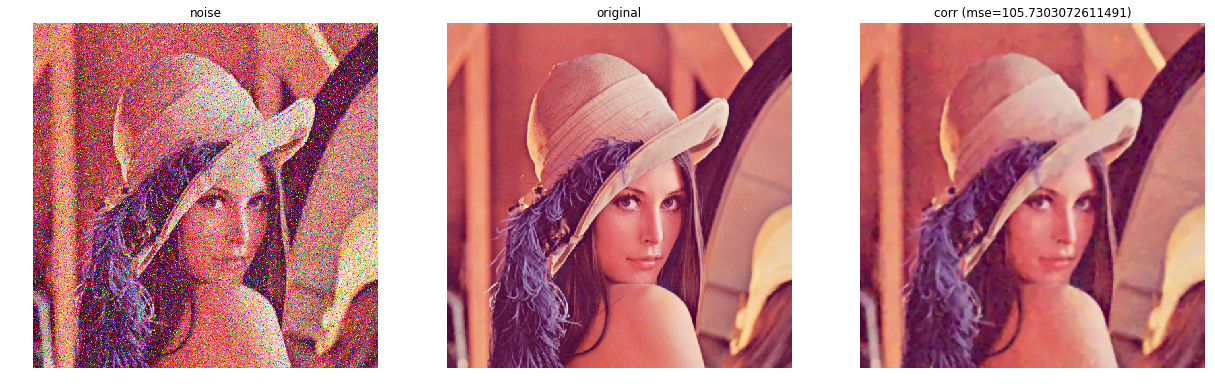

In [20]:
lena_corr = cv2.fastNlMeansDenoisingColored(cv2.medianBlur(lena_noise, 5), None, 5, 5)
error = mse(lena_tiff, lena_corr)
assert error < 150
show([(lena_noise, 'noise'), (lena_tiff, 'original'), (lena_corr, f'corr (mse={error})')])

**8. (5 баллов)** Реализуйте функцию пространственной фильтрации изображения однородным усредняющим фильтром размера $n \times n$ (все коэффициенты маски равны $\frac{1}{n^2}$). При вычислении среднего используйте тот факт, что при переходе от точки к точке обновляется только часть элементов изображения под маской. Примените реализованный фильтр к предварительно переведенному в градации серого изображению $lena.jpg$ при $n = 3$ и $n = 5$. Постройте и сохраните изображение, представляющее собой разность полученных результатов фильтрации.

In [21]:
def mean_filter(img, n):
    w, h = img.shape
    k = n // 2
    
    tmp = np.pad(lena_gray.astype(float), (k, k), 'constant', constant_values=0) / (n ** 2)
    res = np.empty_like(img, dtype=float)
    for y, x in product(range(h), range(w)):
        ty, tx = y + k, x + k
        if tx == k:
            csum = tmp[ty - k:ty + k + 1, tx - k:tx + k + 1].sum()
        else:
            csum += (tmp[ty - k:ty + k + 1, tx + k].sum() \
                     - tmp[ty - k:ty + k + 1, tx - k - 1].sum())
        res[y, x] = csum
    
    return res.astype(np.uint8)

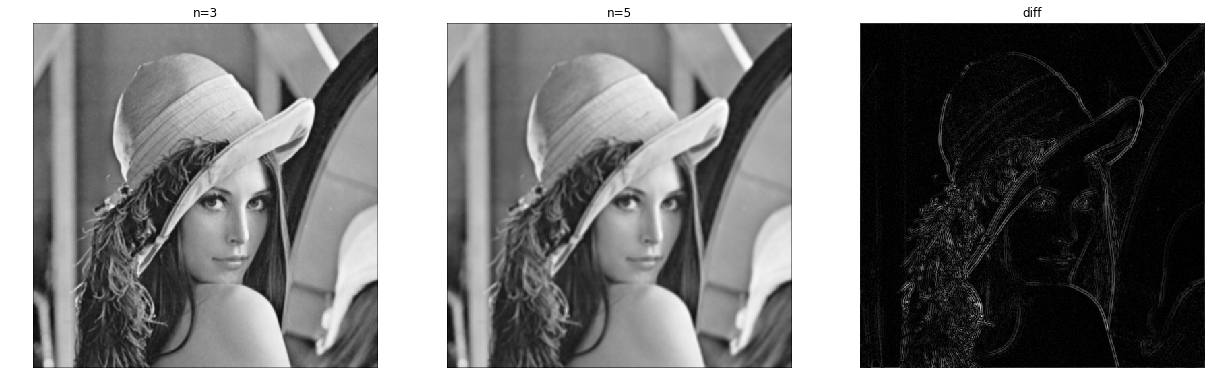

In [22]:
lena_gray_mf3 = mean_filter(lena_gray, 3)
lena_gray_mf5 = mean_filter(lena_gray, 5)
show([(lena_gray_mf3, 'n=3'), (lena_gray_mf5, 'n=5'), (diff(lena_gray_mf3, lena_gray_mf5), 'diff')])